# Prédiction du cours boursier

## Imports

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from statsmodels.tsa.arima.model import ARIMA

from src.functions.arima_parameters import arima_parameters
from src.utils import init_notebook

In [2]:
init_notebook()

In [3]:
data_folder = "data/processed_data/detrend_data/LinearMADetrend/window-100"
stock_name = "AAPL"

In [4]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [5]:
prediction_results_dict = {}

## ARIMA

### Predict new price

In [6]:
# Take close price as target variable
price = df["Close"]

In [7]:
# Example: Fit ARMA(1,1) model
model = ARIMA(price, order=arima_parameters)
fitted_arima = model.fit()

# Display model summary
print(fitted_arima.summary())

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:               ARIMA(10, 0, 10)   Log Likelihood               -1568.804
Date:                Mon, 05 Feb 2024   AIC                           3181.607
Time:                        02:16:51   BIC                           3283.424
Sample:                             0   HQIC                          3220.825
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0503      0.130      0.388      0.698      -0.204       0.305
ar.L1          1.2910      0.235      5.488      0.000       0.830       1.752
ar.L2         -0.5484      0.283     -1.936      0.0

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Make predictions

forecast_steps = 60  # N days to forecast
forecast = fitted_arima.get_forecast(steps=forecast_steps)

date_range = pd.date_range(
    price.index[-1], periods=forecast_steps + 1, freq=price.index.freq
)
forecast_index = date_range[1:]  # Exclude price.index[-1]

predicted_values = forecast.predicted_mean

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


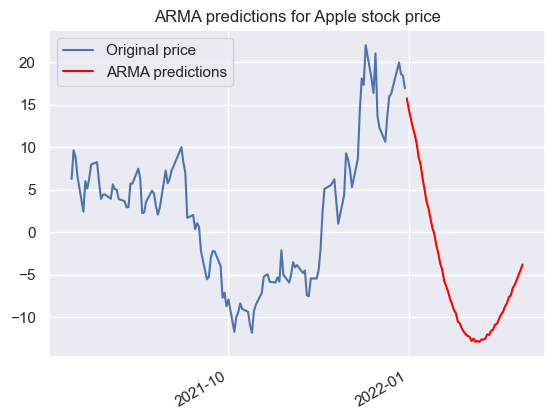

In [9]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(price[-plot_n_days_prior_pred:], label="Original price")
plt.plot(forecast_index, predicted_values, label="ARMA predictions", color="red")
plt.title("ARMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

### Train test split

In [10]:
train_test_split_date = pd.Timestamp("2021-10-01")
train, test = (
    price[price.index <= train_test_split_date],
    price[price.index > train_test_split_date],
)

In [11]:
model = ARIMA(train, order=arima_parameters)
result = model.fit()

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtual

In [12]:
forecast_steps = len(test)
forecast = result.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


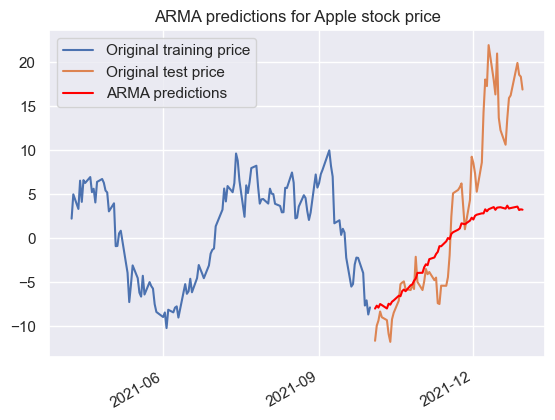

In [13]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(train[-plot_n_days_prior_pred:], label="Original training price")
plt.plot(test, label="Original test price")
plt.plot(test.index, predicted_values, label="ARMA predictions", color="red")
plt.title("ARMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

## XGBoost

In [73]:
import xgboost
from sklearn.linear_model import LinearRegression

### Traitement des données

In [148]:
train_start_date = "2019"
train_end_date = "2021-10-01"
df_train = df.loc[train_start_date:train_end_date].copy()
df_test = df.loc[train_end_date:].copy()

In [149]:
df_train["time_dummy"] = range(len(df_train))
df_test["time_dummy"] = range(len(df_test))
df_test["time_dummy"] += len(df_train)


In [150]:
df_train["time_dummy"].tail()

Date
2021-09-27    689
2021-09-28    690
2021-09-29    691
2021-09-30    692
2021-10-01    693
Name: time_dummy, dtype: int64

In [151]:
df_test["time_dummy"].head()

Date
2021-10-01    694
2021-10-04    695
2021-10-05    696
2021-10-06    697
2021-10-07    698
Name: time_dummy, dtype: int64

In [152]:
x = df_train[["time_dummy"]]
y = df_train[["Close"]]

In [153]:
x_test = df_test[["time_dummy"]]
y_test = df_test[["Close"]]

### Apprentissage des modèles

In [219]:
lr = LinearRegression()

In [220]:
xgb = xgboost.XGBRegressor(random_state=0, n_jobs=-2)

In [221]:
lr.fit(x, y)

LinearRegression()

In [222]:
y_residuals = y - lr.predict(x)
xgb.fit(x, y_residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-2,
             num_parallel_tree=None, random_state=0, ...)

In [223]:
def xgb_prediction(xgb: xgboost.XGBRegressor, lr: LinearRegression, x):
    lr_predict = lr.predict(x).reshape(-1, 1)
    y_pred = xgb.predict(x).reshape(-1, 1)

    return y_pred + lr_predict

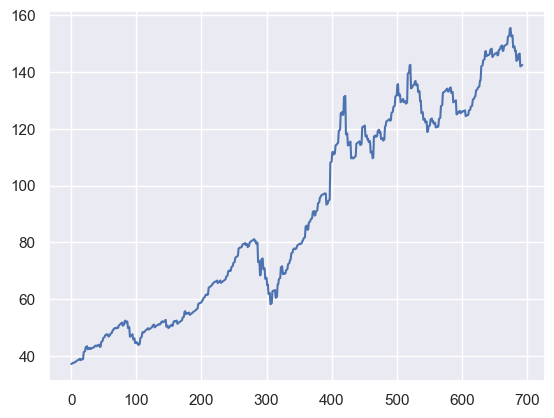

In [217]:
plt.plot(xgb_prediction(xgb, lr, x))

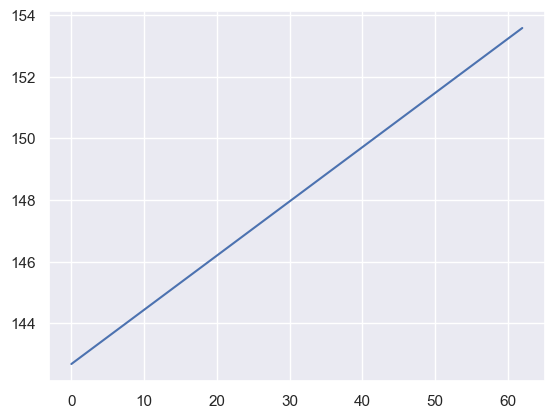

In [218]:
plt.plot(xgb_prediction(xgb, lr, x_test))

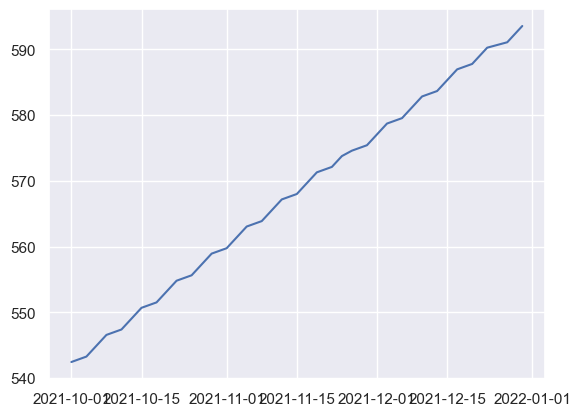

In [186]:
plt.plot(x_test - lr.predict(x_test))

In [173]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

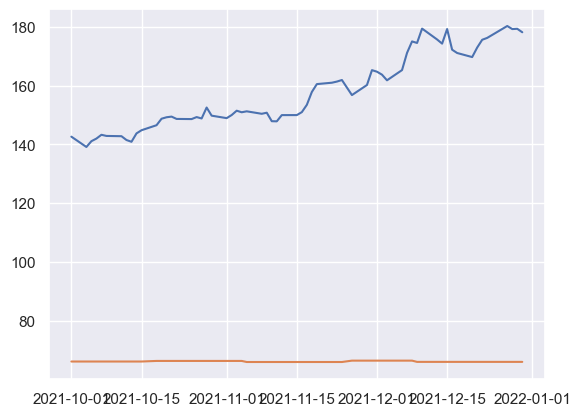

In [174]:

plt.plot(df_test[["Close"]])
plt.plot(y_pred)

## Prophet

### Pré-traitement pour Prophet

In [24]:
# relecture des données (sans detrend)
data_folder = "data/raw_data"
stock_name = "AAPL"
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [25]:
df_train = df.loc[train_start_date:train_end_date]

In [26]:
df_train.shape

(694, 6)

In [27]:
x = df_train[[]].copy()

In [28]:
x["ds"] = df_train.index
x["y"] = df_train[["Close"]]

In [29]:
x.head()

,ds,y
Date,,
2019-01-02,2019-01-02,39.480000
2019-01-03,2019-01-03,35.547501
2019-01-04,2019-01-04,37.064999
2019-01-07,2019-01-07,36.982498
2019-01-08,2019-01-08,37.687500


### Prédiction

#### Calcul de la prédiction

In [30]:
model = Prophet()
model.fit(x)

02:16:56 - cmdstanpy - INFO - Chain [1] start processing
02:16:56 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future = model.make_future_dataframe(periods=100)
future.tail()

,ds
789,2022-01-05
790,2022-01-06
791,2022-01-07
792,2022-01-08
793,2022-01-09


In [32]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
789,2022-01-05,166.742999,159.612190,173.837596
790,2022-01-06,166.593156,159.729860,174.115085
791,2022-01-07,166.485685,159.388446,173.885798
792,2022-01-08,174.417874,167.607391,181.874324
793,2022-01-09,174.421259,167.899601,182.152468


#### Affichage de la prédiction

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


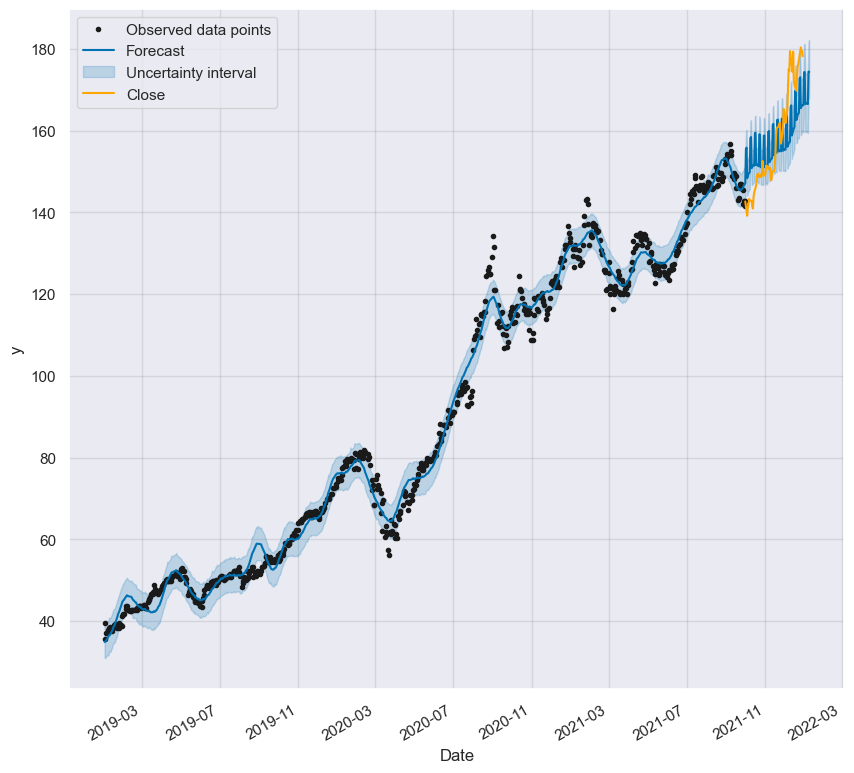

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig1 = model.plot(forecast, ax=ax1)
df[["Close"]].loc[train_end_date:].plot(ax=ax1, color="orange")
plt.legend()

- beaucoup de variations _(dues au fait que nous n'avons pas de données pour les weekends)_
- la vraie valeur est très souvent dans l'intervalle de confiance

### Décomposition

C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\AB2-PC\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-59_ARg3a-py3.10\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of

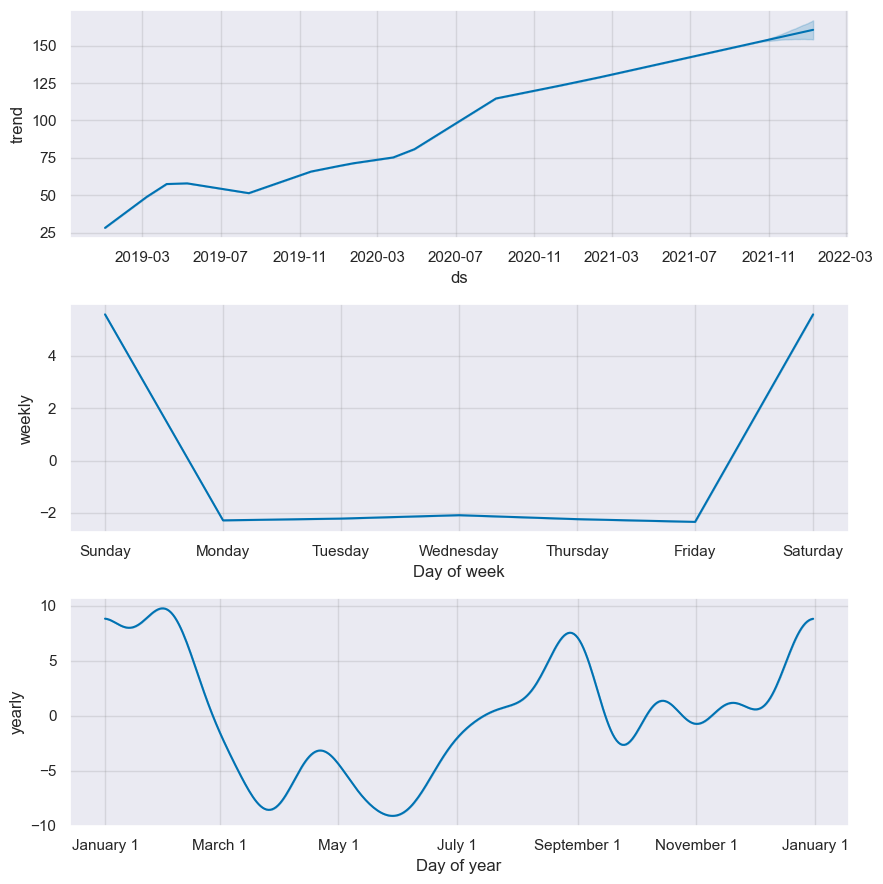

In [34]:
fig2 = model.plot_components(forecast)

### Métriques de prédiction

In [35]:
# we redo the prediction because currently we do not handle the weekends with Prophet
# (since weekends data do not exist in stock data)
model = Prophet()
model.fit(x)
future = model.make_future_dataframe(periods=62)
future.tail()
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

02:16:57 - cmdstanpy - INFO - Chain [1] start processing
02:16:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
751,2021-11-28,162.895645,158.063607,167.514724
752,2021-11-29,155.053766,150.171226,160.114078
753,2021-11-30,155.172747,149.914728,160.062911
754,2021-12-01,155.375946,150.407402,160.172633
755,2021-12-02,155.324346,150.054572,160.484830


In [36]:
forecast.index = df.index

In [37]:
y_true = df[["Close"]].loc[train_end_date:]
y_pred = forecast[["yhat"]].iloc[-y_true.shape[0] :]

In [38]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 11.965935077902962
MAE: 9.370173438133252
MAPE: 0.05752552153894722%


In [39]:
prediction_results_dict["Prophet"] = [rmse, mae, mape]

## Comparaison des modèles

In [40]:
prediction_results_df = pd.DataFrame(prediction_results_dict).T
prediction_results_df.columns = ["RMSE", "MAE", "MAPE"]
prediction_results_df

,RMSE,MAE,MAPE
Prophet,11.965935,9.370173,0.057526


In [41]:
print(prediction_results_df.to_markdown())

|         |    RMSE |     MAE |      MAPE |
|:--------|--------:|--------:|----------:|
| Prophet | 11.9659 | 9.37017 | 0.0575255 |
